## Import necessarry dependencies

In [1]:
import pandas as pd
import math
from auxFonctions import AminoAcid
import fonctionsSupervisedLearning2 as fsl2
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import svm

from Bio.Align import substitution_matrices


/var/folders/wp/4cr2jl295bs4z4czxy_p6w5m0000gn/T/ipykernel_39520/525739334.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Redoing fast the Statistical Study in order to get the s values

In [2]:
# Read data from a file into a list of entries
with open('data/SIG_13.red', 'r') as file:
    entries = file.read().split('\n   ')


# Define a function to process each entry in the data file
def process_entry(entry):
    lines = entry.split('\n')
    protein_id, primary_structure, annotation = lines
    return {
        'Protein ID': protein_id.split()[1],
        'Primary Structure': primary_structure,
        'Annotation': annotation
    }


# Process each entry
processed_entries = [process_entry(entry) for entry in entries]

# Create a DataFrame
df = pd.DataFrame(processed_entries)
df['Cleavage_Site'] = df['Annotation'].apply(lambda x: x.find('C'))

# Now you can analyze the DataFrame as needed

In [3]:
# Get the position of the cleavage site
cleavage_site_position = df['Cleavage_Site']
#print("Position of the cleavage site:")
#print(cleavage_site_position)
print("Average position of the cleavage site:")
print(cleavage_site_position.mean())
print("\n")

print("The extremum position of the cleavage site:")
print(cleavage_site_position.min())
print(cleavage_site_position.max())

print("The distance from cleavage site to the C-terminal part of the amino-sequence:")
#there is always 30 amino-acids after the cleavage site
print("\n")\

# with have then p = [13, 1] and q = [1, 30]

Average position of the cleavage site:
24.04971590909091


The extremum position of the cleavage site:
13
90
The distance from cleavage site to the C-terminal part of the amino-sequence:




In [4]:
# Split the primary structure into a list of amino acids
amino_acid_seq = df['Primary Structure'].apply(lambda x: list(x))

# Create a DataFrame to store, for each primary structure, the neihborhood of the cleavage site
# The neighborhood is defined as the word of length p+q starting p letters before the cleavage site
# correct_neighborhood = pd.Series(index=amino_acid_seq.index, dtype=str)
# for i, seq in amino_acid_seq.items():
    # correct_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-13:cleavage_site_position[i]+2])

# for each amino acid in the sequence, replace it with the corresponding AminoAcid object
amino_acid_seqB = amino_acid_seq
amino_acid_seq = amino_acid_seq.apply(lambda x: [AminoAcid(aa) for aa in x])


In [5]:
#Parametres de l'étude
p = 13
q = 8

# Create a DataFrame to store the counts of each amino acid at every position relative to the cleavage site
#the cleavage site is between to aminoacids, so cleavage_site_position is the position of the first amino acid after the cleavge site
#So i need to create a dataframe with columns from -p to q without 0
amino_acid_counts = pd.DataFrame(0, index=AminoAcid.properties.keys(), columns=range(-p, q))
amino_acid_freqs = pd.DataFrame(0.0, index=AminoAcid.properties.keys(), columns=range(-p, q)) #f(a,i)
amino_acid_pseudo_counts = pd.DataFrame(0, index=AminoAcid.properties.keys(), columns=range(-p, q)) #g(a)
amino_acid_s_values = pd.DataFrame(0.0, index=AminoAcid.properties.keys(), columns=range(-p, q)) #s(a,i)


# Count the occurrences of each amino acid at every position relative to the cleavage site

for i, seq in amino_acid_seq.items():
    for j, aa in enumerate(seq):
        position = j - cleavage_site_position[i] #position of the amino acid relative to the cleavage site
        if position in amino_acid_counts.columns:
            amino_acid_counts.loc[aa.code, position] += 1

# Add pseudo-counts to avoid zero counts here pseudocount parameter is 1/len(df)
amino_acid_pseudo_counts = amino_acid_counts + 1

# Print the results
#print("Occurrences of each amino acid at every position relative to the cleavage site:")
#print(amino_acid_pseudo_counts)

# Compute the observed frequency of each amino acid at the relative position (using pseudo-counts)
for i in amino_acid_counts.index:
    for j in amino_acid_counts.columns:
        amino_acid_freqs.loc[i, j] = amino_acid_pseudo_counts.loc[i, j] / len(df)

# Compute the general background frequency of each amino acid
general_background_frequency = amino_acid_freqs.mean(axis=1)

# Compute the s value of each amino acid at every position
for i in amino_acid_counts.index:
    for j in amino_acid_counts.columns:
        amino_acid_s_values.loc[i, j] = math.log(amino_acid_freqs.loc[i, j]) - math.log(general_background_frequency[i])

In [7]:
# Create a DataFrame to store, for each primary structure, the neihborhood of the cleavage site
# The neighborhood is defined as the word of length p+q starting p letters before the cleavage site
correct_neighborhood = pd.Series()
for i, seq in amino_acid_seqB.items():
    correct_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-p:cleavage_site_position[i]+q])

# Create a DataFrame to store, for each primary structure, a sequence that is not the neighborhood of the cleavage site
incorrect_neighborhood = pd.Series()
decalage  = [1,2,3,4,5, -1,-2,-3,-4, -5]
for i, seq in amino_acid_seqB.items():
    dec = np.random.choice(decalage)
    dec = 0 if cleavage_site_position[i]-13 - dec < 0 else dec
    incorrect_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-p-dec:cleavage_site_position[i]+q-dec])


In [7]:
# Define the function computing the q-1 score for a given word
def q_minus_1_score(word):
    return sum([amino_acid_s_values.loc[aa, i-p] for i, aa in enumerate(word)])


#A REDEFINIR EN FONCTION DES RESULTATS OBTENUS
threshold = 1.5
print(threshold)

#A simple thresholding (to be tuned) is then enough to define a simple binary classifier.
def is_cleavage_neighborhood(score):
    return score > threshold

q_minus_1_score('AAAAAAAAAAAAAAA')

1.5


-2.302718213229582

In [8]:
# To obtain the score of the correct neighborhoods, we apply the q-1 score function to each neighborhood
#correct_neighborhood = correct_neighborhood.apply(lambda x: [AminoAcid(aa) for aa in x])
correct_neigboorhood_score = correct_neighborhood.apply(q_minus_1_score)
incorrect_neighborhood_score = incorrect_neighborhood.apply(q_minus_1_score)

#print("Score of the correct neighborhoods:")
#print(correct_neigboorhood_score)
#print("\n")

print("Mean score of the correct neighborhoods:")
print(correct_neigboorhood_score.mean())
print("\n")

print("Mean score of the incorrect neighborhoods:")
print(incorrect_neighborhood_score.mean())
print("\n")

print("Standard deviation of the score of the correct neighborhoods:")
print(correct_neigboorhood_score.std())

print("Standard deviation of the score of the incorrect neighborhoods:")
print(incorrect_neighborhood_score.std())

print("Min and max values of the correct neighboorhoods score :")
print(correct_neigboorhood_score.min())
print(correct_neigboorhood_score.max())

print("Min and max values of the incorrect neighboorhoods score :")
print(incorrect_neighborhood_score.min())
print(incorrect_neighborhood_score.max())

#We now test, with the updated threshold, the performance of the classifier on the training set
# Treshold = mean - std
false_negatives = correct_neigboorhood_score[correct_neigboorhood_score < threshold].count()
print("False negative out of "+str(len(correct_neighborhood))+ " entries:")
print(false_negatives)

false_positives = incorrect_neighborhood_score[incorrect_neighborhood_score > threshold].count()
print("False positive out of "+str(len(incorrect_neighborhood))+ " entries:")
print(false_positives)





Mean score of the correct neighborhoods:
3.2162682210182796


Mean score of the incorrect neighborhoods:
-1.3224233008951194


Standard deviation of the score of the correct neighborhoods:
2.5872637135991514
Standard deviation of the score of the incorrect neighborhoods:
2.6423653344091234
Min and max values of the correct neighboorhoods score :
-7.931205228611351
9.452566054567916
Min and max values of the incorrect neighboorhoods score :
-9.668207249178218
7.5408049693551575
False negative out of 1408 entries:
288
False positive out of 1408 entries:
183


## UTILISATION DES RESULTATS POUR CREER LA KERNEL PROBABILISTE

In [24]:
def est_un_caractere(obj):
    return isinstance(obj, str) and len(obj) == 1

def Phi(x : chr, y : chr, i : int) :
    if not(est_un_caractere(x) and est_un_caractere(y)) :
        raise ValueError("x and y must be single characters")
    '''
    Fonction servant de base a la Kernel probabiliste
    ### Parameters:
    - x : un acide aminé (sous forme de string)
    - y : un acide aminé (sous forme de string)
    - i : un entier compris entre -p et q-1 (inclus)
    ### Returns:
    - La valeur de la fonction Phi_i(x,y)
    '''
    if (x == y) :
        return ( amino_acid_s_values.loc[x, i] + math.log(1 + math.exp(amino_acid_s_values.loc[x, i])) )
    else :
        return ( amino_acid_s_values.loc[x, i] + amino_acid_s_values.loc[y, i] )

def LogKernel(x : str, y : str) :
    '''
    Fonction servant de base a la Kernel probabiliste
    ### Parameters:
    - x : une sequence d'acides aminés de taille p+q (sous forme de string)
    - y : une sequence d'acides aminés de taille p+q (sous forme de string)
    ### Returns:
    - La valeur de la fonction LogKernel(x,y)
    '''
    sum = 0
    for i in range(-p, q) :
        sum += Phi(x[p+i], y[p+i], i)
        #print("Sum :"+ str(sum))
    return sum

"""
def ProbalisticKernel(X, Y):
    # Initialize an empty matrix to store the kernel values
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))

    # Calculate the kernel value for each pair of samples
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            x_str = fsl2.vector_to_word(x)
            y_str = fsl2.vector_to_word(y)
            gram_matrix[i, j] = math.exp(LogKernel(x_str, y_str))

    return gram_matrix
"""

def ProbKernel(x, y):
    X_str = fsl2.vector_to_word(x)
    Y_str = fsl2.vector_to_word(y)
    # print(len(X_str))
    # print(len(Y_str))
    '''
    Fonction servant de base a la Kernel probabiliste
    ### Parameters:
    - x : une sequence d'acides aminés converti au prealable en vecteur de taille (p+q)*26 composé de 0 et 1
    - y : une sequence d'acides aminés converti au prealable en vecteur de taille (p+q)*26 composé de 0 et 1
    ### Returns:
    - La valeur de la fonction Kernel(x,y)
    '''
    return math.exp(LogKernel(X_str, Y_str))

def ProbabilisticKernel(X, Y):
    # Initialize an empty matrix to store the kernel values
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))

    # Calculate the kernel value for each pair of samples
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            gram_matrix[i, j] = ProbKernel(x, y)

    return gram_matrix

In [11]:
x = fsl2.word_to_vector(correct_neighborhood[0])
y = fsl2.word_to_vector(correct_neighborhood[1])

print(ProbKernel(x, y))

4346677.599274866


## KERNEL ISSUE DES MATRICES DE SUBSTITUTION

In [11]:
pam250 = substitution_matrices.load("PAM250")
blosum62 = substitution_matrices.load("BLOSUM62")

# Access scores directly
score_AR = pam250[('A', 'K')]
print("Score for A and R:", score_AR)

score_AA = pam250['A', 'A']
print("Score for A and A:", score_AA)

score_AA = blosum62['A', 'A']
print("Score for A and A:", score_AA)

Score for A and R: -1.0
Score for A and A: 2.0
Score for A and A: 4.0


In [12]:
#Fonction indiquant la similarité entre deux sequences d'acides aminés
def SimilarityPAM(x : str, y : str) :
    '''
    Fonction servant de base a la Kernel probabiliste
    ### Parameters:
    - x : une sequence d'acides aminés de taille p+q (sous forme de string)
    - y : une sequence d'acides aminés de taille p+q (sous forme de string)
    ### Returns:
    - La valeur de la fonction Similarity(x,y)
    '''
    sum = 0
    for i in range(-p, q) :
        sum += pam250[(x[p+i], y[p+i])]
    return sum

def SimilarityBLOSUM(x : str, y : str) :
    '''
    Fonction servant de base a la Kernel probabiliste
    ### Parameters:
    - x : une sequence d'acides aminés de taille p+q (sous forme de string)
    - y : une sequence d'acides aminés de taille p+q (sous forme de string)
    ### Returns:
    - La valeur de la fonction Similarity(x,y)
    '''
    sum = 0
    for i in range(-p, q) :
        sum += blosum62[x[p+i], y[p+i]]
    return sum

def RBF_similarity(x : str, y : str, sigma = 1, SUBSTITUTION_MATRIX = "PAM") :
    '''
    Fonction servant de base a la Kernel de similarité
    ### Parameters:
    - x : une sequence d'acides aminés de taille p+q (sous forme de string)
    - y : une sequence d'acides aminés de taille p+q (sous forme de string)
    - sigma : un reel positif
    ### Returns:
    - La valeur de la fonction Similarity(x,y)
    '''
    if (SUBSTITUTION_MATRIX == "PAM") :
        Similarity = SimilarityPAM
    elif (SUBSTITUTION_MATRIX == "BLOSUM") :
        Similarity = SimilarityBLOSUM
    return math.exp(-Similarity(x, y) / (2 * sigma**2))

def RBF_kernelPAM(X, Y) :
    '''
    Fonction servant de base a la Kernel RBF (Radial Basis Function) par similarité
    ### Parameters:
    - x : une sequence d'acides aminés converti au prealable en vecteur de taille (p+q)*26 composé de 0 et 1
    - y : une sequence d'acides aminés converti au prealable en vecteur de taille (p+q)*26 composé de 0 et 1
    ### Returns:
    - La valeur de la fonction Kernel(x,y)
    '''
    # Initialize an empty matrix to store the kernel values
    Xb = X
    Yb = Y
    if Xb.ndim == 1:
        Xb = np.array([Xb])
    if Yb.ndim == 1:
        Yb = np.array([Yb])
    gram_matrix = np.zeros((Xb.shape[0], Yb.shape[0]))

    # Calculate the kernel value for each pair of samples
    for i, x in enumerate(Xb):
        X_str = fsl2.vector_to_word(x)
        for j, y in enumerate(Yb):
            Y_str = fsl2.vector_to_word(y)
            gram_matrix[i, j] = RBF_similarity(X_str, Y_str, sigma = 0.5, SUBSTITUTION_MATRIX = "PAM") 

    return gram_matrix

def RBF_kernelBLOSUM(X, Y) :
    '''
    Fonction servant de base a la Kernel RBF (Radial Basis Function) par similarité
    ### Parameters:
    - x : une sequence d'acides aminés converti au prealable en vecteur de taille (p+q)*26 composé de 0 et 1
    - y : une sequence d'acides aminés converti au prealable en vecteur de taille (p+q)*26 composé de 0 et 1
    ### Returns:
    - La valeur de la fonction Kernel(x,y)
    '''
    # Initialize an empty matrix to store the kernel values
    Xb = X
    Yb = Y
    if Xb.ndim == 1:
        Xb = np.array([Xb])
    if Yb.ndim == 1:
        Yb = np.array([Yb])
    gram_matrix = np.zeros((Xb.shape[0], Yb.shape[0]))

    # Calculate the kernel value for each pair of samples
    for i, x in enumerate(Xb):
        X_str = fsl2.vector_to_word(x)
        for j, y in enumerate(Yb):
            Y_str = fsl2.vector_to_word(y)
            gram_matrix[i, j] = RBF_similarity(X_str, Y_str, sigma = 5, SUBSTITUTION_MATRIX = "BLOSUM") 

    return gram_matrix


## Traitement des données

In [13]:
df_exploitable = fsl2.convert_df_to_vectors2(df)

## Developpement et entrainement du modèle probabiliste

In [14]:
p = 13
q = 2

n = p+q
correct_neighborhood = pd.Series()
for i, seq in amino_acid_seqB.items():   
    correct_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-p:cleavage_site_position[i]+q])

incorrect_neighborhood = pd.Series()
decalage  = [1,2,3,4,5, -1,-2,-3,-4, -5]
for i, seq in amino_acid_seqB.items():
    dec = np.random.choice(decalage)
    dec = 0 if cleavage_site_position[i]-13 - dec < 0 else dec
    incorrect_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-p-dec:cleavage_site_position[i]+q-dec])
            
X_train, X_test, bool_train, bool_test = fsl2.test_train_split_random_pos2(df_exploitable, n, p)

gram_matrix = ProbabilisticKernel(X_train, X_train)
probabilisticClassifier = svm.SVC(kernel='precomputed')

probabilisticClassifier.fit(gram_matrix, bool_train)
        
gram_matrix_test = ProbabilisticKernel(X_test, X_train)

bool_pred = probabilisticClassifier.predict(gram_matrix_test)
        
accuracy = accuracy_score(bool_test, bool_pred)
        

count_fn = 0
for i in range(0, len(correct_neighborhood)):
    x = np.array([fsl2.word_to_vector(correct_neighborhood.get(i))])
    K_x = ProbabilisticKernel(x, X_train)
    test = probabilisticClassifier.predict(K_x)
    if not(test):
        count_fn += 1

count_fp = 0
for i in range(0, len(incorrect_neighborhood)):
    x = np.array([fsl2.word_to_vector(incorrect_neighborhood.get(i))])
    K_x = ProbabilisticKernel(x, X_train)
    test = probabilisticClassifier.predict(K_x)
    if test:
        count_fp += 1
        
print("False negatives: ", count_fn)
print("False positives: ", count_fp)
print("Accuracy: ", accuracy)

/Users/mathiasperez/Documents/GitHub/442-2-Protein-cleavage/fonctionsSupervisedLearning2.py:132: SyntaxWarning: invalid escape sequence '\ '
  '''


KeyboardInterrupt: 

In [19]:
p_list = [7, 9, 11, 13]
q_list = [2, 4, 6, 8]
results = []

for p in p_list:
    for q in q_list:
        n = p+q
        correct_neighborhood = pd.Series()
        for i, seq in amino_acid_seqB.items():   
            correct_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-p:cleavage_site_position[i]+q])

        incorrect_neighborhood = pd.Series()
        decalage  = [1,2,3,4,5, -1,-2,-3,-4, -5]
        for i, seq in amino_acid_seqB.items():
            dec = np.random.choice(decalage)
            dec = 0 if cleavage_site_position[i]-13 - dec < 0 else dec
            incorrect_neighborhood[i] = ''.join(seq[cleavage_site_position[i]-p-dec:cleavage_site_position[i]+q-dec])
            
        X_train, X_test, bool_train, bool_test = fsl2.test_train_split_random_pos2(df_exploitable, n, p)

        gram_matrix = ProbabilisticKernel(X_train, X_train)
        probabilisticClassifier = svm.SVC(kernel='precomputed')

        probabilisticClassifier.fit(gram_matrix, bool_train)
        
        gram_matrix_test = ProbabilisticKernel(X_test, X_train)

        bool_pred = probabilisticClassifier.predict(gram_matrix_test)
        
        accuracy = accuracy_score(bool_test, bool_pred)
        

        count_fn = 0
        for i in range(0, len(correct_neighborhood)):
            x = np.array([fsl2.word_to_vector(correct_neighborhood.get(i))])
            K_x = ProbabilisticKernel(x, X_train)
            test = probabilisticClassifier.predict(K_x)
            if not(test):
                count_fn += 1

        count_fp = 0
        for i in range(0, len(incorrect_neighborhood)):
            x = np.array([fsl2.word_to_vector(incorrect_neighborhood.get(i))])
            K_x = ProbabilisticKernel(x, X_train)
            test = probabilisticClassifier.predict(K_x)
            if test:
                count_fp += 1
            
        results.append((p, q, accuracy, count_fn/len(correct_neighborhood), count_fp/len(incorrect_neighborhood)))

results_df = pd.DataFrame(results, columns=['p', 'q', 'Accuracy', 'False negative rate', 'False positive rate'])
results_df.to_csv('resultsProba.csv', index=True)

In [20]:
# i want model with the lowest false negative and false positive
#I have to sort the results_df by false negative + false positive
results_df['sum'] = results_df['False negative rate'] + results_df['False positive rate']
results_df = results_df.sort_values(by='sum')
results_df.to_csv('resultsProba_sorted.csv', index=True)

In [21]:
best_results = results_df.loc[(results_df['Accuracy']).idxmax()]
print(best_results)

p                      9.000000
q                      2.000000
Accuracy               0.868794
False negative rate    0.127131
False positive rate    0.143466
sum                    0.270597
Name: 4, dtype: float64


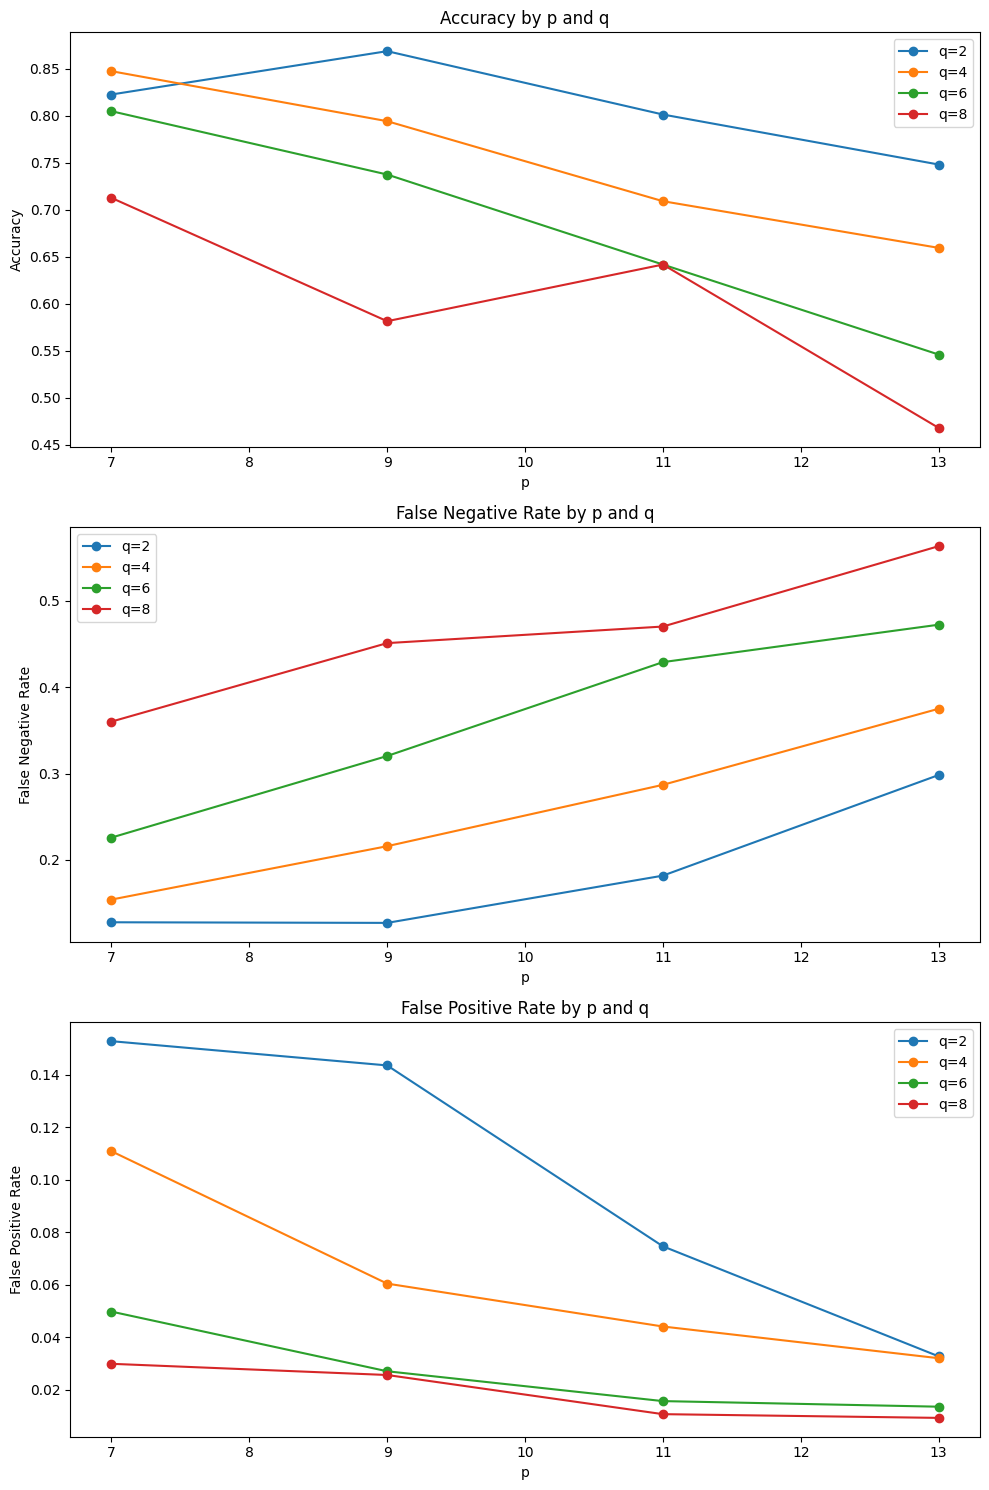

In [27]:
# Load the results DataFrame
results_df = pd.read_csv('resultsProba.csv')

# Set up subplots for each metric
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot accuracy by p and q
accuracy_pq = results_df.pivot(index='p', columns='q', values='Accuracy')
for q in accuracy_pq.columns:
    axs[0].plot(accuracy_pq.index, accuracy_pq[q], label=f'q={q}', marker='o')
axs[0].set_title('Accuracy by p and q')
axs[0].set_xlabel('p')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot false negative rate by p and q
fn_rate_pq = results_df.pivot(index='p', columns='q', values='False negative rate')
for q in fn_rate_pq.columns:
    axs[1].plot(fn_rate_pq.index, fn_rate_pq[q], label=f'q={q}', marker='o')
axs[1].set_title('False Negative Rate by p and q')
axs[1].set_xlabel('p')
axs[1].set_ylabel('False Negative Rate')
axs[1].legend()

# Plot false positive rate by p and q
fp_rate_pq = results_df.pivot(index='p', columns='q', values='False positive rate')
for q in fp_rate_pq.columns:
    axs[2].plot(fp_rate_pq.index, fp_rate_pq[q], label=f'q={q}', marker='o')
axs[2].set_title('False Positive Rate by p and q')
axs[2].set_xlabel('p')
axs[2].set_ylabel('False Positive Rate')
axs[2].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [25]:
#Let's save the best model
p = 9
q = 2
n = p+q
X_train, X_test, bool_train, bool_test = fsl2.test_train_split_random_pos2(df_exploitable, 11, 9)


gram_matrix = ProbabilisticKernel(X_train, X_train)

np.save('gram_matrix_proba.npy', gram_matrix)

In [26]:
probabilisticClassifier = svm.SVC(kernel='precomputed')

probabilisticClassifier.fit(gram_matrix, bool_train)

SVC(kernel='precomputed')

In [29]:
x = correct_neighborhood.get(2)
print(x)
x = fsl2.word_to_vector(x)
x = np.array([x])
k_x = ProbabilisticKernel(x, X_train)
print(x)
test = probabilisticClassifier.predict(k_x)
print(test)

LLSAALALTETWAGS
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0.

In [20]:
count_fn = 0
for i in range(0, len(correct_neighborhood)):
    x = np.array([fsl2.word_to_vector(correct_neighborhood.get(i))])
    K_x = ProbabilisticKernel(x, X_train)
    test = probabilisticClassifier.predict(K_x)
    if not(test):
        count_fn += 1

print("Nombre de faux négatifs :" + str(count_fn))

count_fp = 0
for i in range(0, len(incorrect_neighborhood)):
    try : 
        x = np.array([fsl2.word_to_vector(incorrect_neighborhood.get(i))])
        K_x = ProbabilisticKernel(x, X_train)
        test = probabilisticClassifier.predict(K_x)
        if test:
            count_fp += 1
    except:
        print("Erreur" + str(i))
        #print(incorrect_neighborhood.get(i))


print("Nombre de faux positifs :" + str(count_fp))
print("Nombre total :" + str(len(correct_neighborhood)))

Nombre de faux négatifs :379
Nombre de faux positifs :47
Nombre total :1408


## Developpement et entrainement du modèle similarité


In [24]:
X_train, X_test, bool_train, bool_test = test_train_split_random_pos_proba(df_exploitable, n)

count_true = 0
count_all = 0
for t in bool_train:
    count_all += 1
    if t:
        count_true += 1
print(count_true)
print(count_all)


570
1126


In [25]:


clf_BLOSUM = svm.SVC(kernel=RBF_kernelBLOSUM)
clf_BLOSUM.fit(X_train, bool_train)

bool_pred_BLOSUM = clf_BLOSUM.predict(X_test)


print("Accuracy score with sigma = 0.5 and BLOSUM:")
print(accuracy_score(bool_test, bool_pred_BLOSUM))

Accuracy score with sigma = 0.5 and BLOSUM:
0.13829787234042554


In [ ]:
x = correct_neighborhood.get(0)
print(x)
x = fsl2.word_to_vector(x)
x = np.array([x])
print(x)
test = clf_BLOSUM.predict(x)
print(test)
if not(test) :
    print("test")

LLAFTLLFATCIARH
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0.

In [ ]:
count_fn = 0
for i in range(0, len(correct_neighborhood)):
    x = np.array([fsl2.word_to_vector(correct_neighborhood.get(i))])
    test = clf_BLOSUM.predict(x)
    if (test == 0):
        count_fn += 1

print("Nombre de faux négatifs :" + str(count_fn))

count_fp = 0
for i in range(0, len(incorrect_neighborhood)):
    try : 
        x = np.array([fsl2.word_to_vector(incorrect_neighborhood.get(i))])
        test = clf_BLOSUM.predict(x)
        if (test == 1):
            count_fp += 1
    except:
        print("Erreur" + str(i))
        #print(incorrect_neighborhood.get(i))


print("Nombre de faux positifs :" + str(count_fp))
print("Nombre total :" + str(len(correct_neighborhood)))

Nombre de faux négatifs :1193
Nombre de faux positifs :798
Nombre total :1408
